# Assignment 12: Decision Tree Classifier

## Data Preprocessing

In [137]:
from sklearn.datasets import load_iris
import numpy as np

iris = load_iris()

num_recs = iris['data'].shape[0]
num_recs = int(2 * num_recs / 3)

feats = iris['data'][:num_recs]

# Swap Setosa and Versicolor labels
labels = 1 - iris['target'][:num_recs]

def interleave(arr: np.ndarray) -> None:
    len = arr.shape[0]
    for i in range(0, int(len / 2), 2):
        temp = arr[i].copy()
        arr[i] = arr[len - i - 1]
        arr[len - i - 1] = temp

interleave(feats)
interleave(labels)

num_train = int(0.8 * num_recs)

X_train = feats[:num_train]
y_train = labels[:num_train]

X_test = feats[num_train:]
y_test = labels[num_train:]

## Decision Tree Implementation

In [138]:
import math
from typing import Union

def calculate_entropy(ys: np.ndarray) -> np.ndarray:
    num_ones = np.count_nonzero(ys)
    p = num_ones / ys.shape[0]

    if p == 0 or p == 1:
        return 0

    return -p * math.log2(p) - (1 - p) * math.log2(1 - p)

def information_gain(ys: np.ndarray, ys_left: np.ndarray, ys_right: np.ndarray) -> float:
    return calculate_entropy(ys) - (calculate_entropy(ys_left) + calculate_entropy(ys_right))

def best_split(Xs: np.ndarray, ys: np.ndarray) -> tuple:
    max_ig = 0

    for i in range(Xs.shape[1]):
        col = Xs[:, i]
        min = np.min(col)
        max = np.max(col)
        diff = max - min

        num_thres_samples = 10
        thres_sample_step = diff / (num_thres_samples + 1)

        for j in range(1, num_thres_samples + 1):
            thres = min + j * thres_sample_step

            less_than_mask = col < thres
            ys_left = ys[less_than_mask]
            ys_right = ys[np.logical_not(less_than_mask)]

            ig = information_gain(ys, ys_left, ys_right)
            if ig > max_ig:
                max_ig = ig
                max_ig_thres = thres
                max_ig_feat_idx = i

    return max_ig_feat_idx, max_ig_thres, max_ig

class Node:
    def __init__(self: 'Node', feat_idx: int, thres: float, left_child: Union['Node', np.int64], right_child: Union['Node', np.int64]):
        self.feat_idx = feat_idx
        self.thres = thres
        self.left_child = left_child
        self.right_child = right_child

def build_tree(Xs: np.ndarray, ys: np.ndarray, max_depth: int, ig_thres: float, parent_depth: int = 0, parent_total_ig: float = 0) -> Node:
    if parent_depth == max_depth or parent_total_ig >= ig_thres:
        unique_counts = np.unique_counts(ys)
        return unique_counts.values[np.argsort(unique_counts.counts)[-1]]

    feat_idx, thres, ig = best_split(Xs, ys)

    less_than_mask = Xs[:, feat_idx] < thres
    Xs_left = Xs[less_than_mask]
    ys_left = ys[less_than_mask]

    more_than_mask = np.logical_not(less_than_mask)
    Xs_right = Xs[more_than_mask]
    ys_right = ys[more_than_mask]

    return Node(
        feat_idx,
        thres,
        build_tree(Xs_left, ys_left, max_depth, ig_thres, parent_depth + 1, parent_total_ig + ig),
        build_tree(Xs_right, ys_right, max_depth, ig_thres, parent_depth + 1, parent_total_ig + ig),
    )

def predict_single_instance(X: np.ndarray, tree: Union[Node, np.int64]) -> int:
    if type(tree) is np.int64:
        return tree

    return predict_single_instance(X, tree.left_child if X[tree.feat_idx] < tree.thres else tree.right_child)

def predict_decision_tree(X_test: np.ndarray, tree: Node) -> np.ndarray:
    return np.apply_along_axis(lambda X: predict_single_instance(X, tree), 1, X_test)

tree = build_tree(X_train, y_train, 5, 0.95)

test_acc = np.count_nonzero(predict_decision_tree(X_test, tree) - y_test == 0) / X_test.shape[0]
print(f"Test Acc: {test_acc:.2f}")

Test Acc: 1.00


## Comparision with Scikit-Learn

Test Acc: 1.00


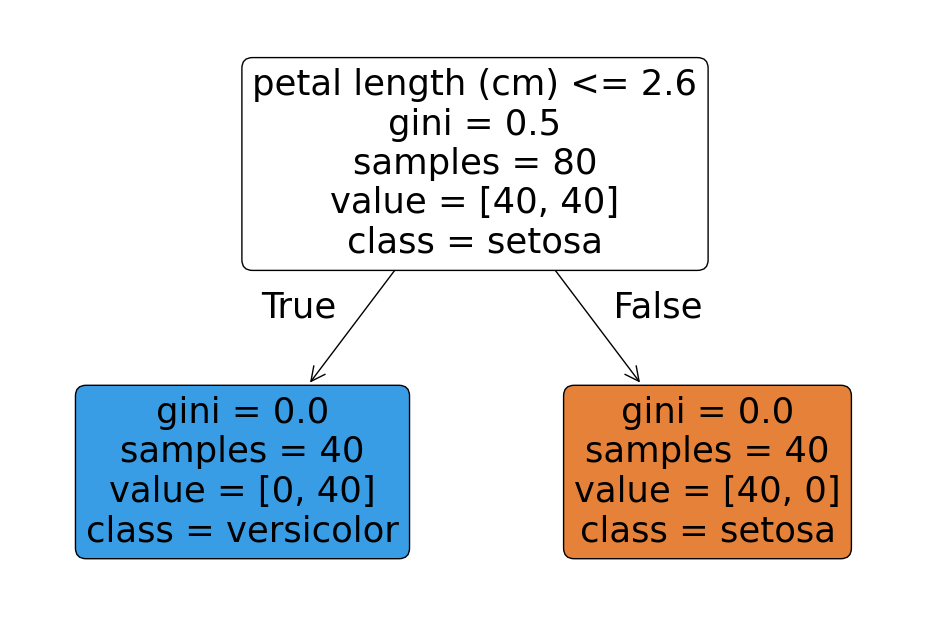

In [139]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Acc: {test_acc:.2f}")

plt.figure(figsize=(12, 8))
tree.plot_tree(clf, filled=True, feature_names=iris.feature_names, class_names=iris.target_names, rounded=True)
plt.show()

## Analysis

- This dataset is too simple to comment on overfitting. (We stop making decision nodes when the net information gain becomes 1, which happens on the very first decision node.)
- Strengths
    - Interpretability
    - Simple and fast inference
- Weaknesses
    - May overfit at times